# Exploratory Data Analysis: Financial Guidance Extraction Pipeline

This notebook performs EDA on the `guidance` table in `finance_data.db` to assess whether the extraction pipeline produces reasonable, high-quality output.

**Objectives:**
- Understand the structure and distribution of extracted guidance data
- Identify data quality issues (missing values, outliers, inconsistencies)
- Visualize key patterns in financial guidance extraction
- Assess pipeline output quality for thesis documentation

## 1. Import Required Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure visualization style for thesis-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data from SQLite Database

Load the `guidance` table and join with `contents` to include publication dates for temporal analysis.

In [2]:
# Connect to the SQLite database
db_path = Path("finance_data.db")
conn = sqlite3.connect(db_path)

# Load guidance table with joined content metadata
query = """
SELECT 
    g.*,
    c.title AS content_title,
    c.published_at,
    c.link AS source_link
FROM guidance g
LEFT JOIN contents c ON g.content_uid = c.uid
"""

df = pd.read_sql_query(query, conn)

# Convert date columns
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
df['extracted_at'] = pd.to_datetime(df['extracted_at'], errors='coerce')

print(f"Loaded {len(df):,} guidance records from database")
print(f"Database path: {db_path.absolute()}")

Loaded 9,568 guidance records from database
Database path: c:\Users\aless\Github\FinanceProject\finance_data.db


## 2.5 Data Provenance & Pipeline Volume

Trace the data flow through the pipeline to understand volume at each stage:
**RSS Pointers → Parsed Contents → Extraction Candidates → Extracted Guidance**

In [33]:
# Data Provenance: Track volume through pipeline stages (by unique document UIDs)
import json

# Stage 1: RSS Pointers (raw feeds) - count unique UIDs
pointers_path = Path("ingestion_json/pointers.json")
if pointers_path.exists():
    with open(pointers_path, 'r', encoding='utf-8') as f:
        pointer_uids = set()
        for line in f:
            if line.strip():
                try:
                    record = json.loads(line)
                    pointer_uids.add(record.get('uid'))
                except:
                    pass
        n_pointers = len(pointer_uids)
else:
    n_pointers = 0

# Stage 2: Parsed Contents (scraped/parsed documents) - count unique UIDs
contents_path = Path("ingestion_json/contents.jsonl")
if contents_path.exists():
    with open(contents_path, 'r', encoding='utf-8') as f:
        content_uids = set()
        for line in f:
            if line.strip():
                try:
                    record = json.loads(line)
                    content_uids.add(record.get('uid'))
                except:
                    pass
        n_contents = len(content_uids)
else:
    n_contents = 0

# Stage 3: Extraction Candidates (filtered for guidance patterns) - count unique UIDs
candidates_path = Path("extractor_lib/candidate_guidance.jsonl")
if candidates_path.exists():
    with open(candidates_path, 'r', encoding='utf-8') as f:
        candidate_uids = set()
        for line in f:
            if line.strip():
                try:
                    record = json.loads(line)
                    candidate_uids.add(record.get('uid'))
                except:
                    pass
        n_candidates = len(candidate_uids)
else:
    n_candidates = 0

# Stage 4: Documents with extracted guidance (unique content_uids from DB)
n_extracted_docs = df['content_uid'].nunique()

# Calculate conversion rates
content_rate = (n_contents / n_pointers * 100) if n_pointers > 0 else 0
candidate_rate = (n_candidates / n_contents * 100) if n_contents > 0 else 0
extraction_rate = (n_extracted_docs / n_candidates * 100) if n_candidates > 0 else 0

print("=" * 70)
print("              DATA PROVENANCE & PIPELINE VOLUME (by Document)")
print("=" * 70)
print(f"""
Pipeline Stage                      Documents    Conversion Rate
{'─' * 70}
1. RSS Pointers (feeds)             {n_pointers:>8,}        (source)
                                                   ↓ {content_rate:>5.1f}%
2. Parsed Contents                  {n_contents:>8,}        
                                                   ↓ {candidate_rate:>5.1f}%
3. Extraction Candidates            {n_candidates:>8,}        (regex filter)
                                                   ↓ {extraction_rate:>5.1f}%
4. Documents with Guidance          {n_extracted_docs:>8,}        (LLM extracted)
{'─' * 70}

Overall: {n_extracted_docs:,} documents yielded guidance from {n_pointers:,} RSS entries ({n_extracted_docs/n_pointers*100 if n_pointers > 0 else 0:.1f}%)
Total guidance items extracted: {len(df):,} (avg {len(df)/n_extracted_docs:.1f} per document)
""")
print("=" * 70)

              DATA PROVENANCE & PIPELINE VOLUME (by Document)

Pipeline Stage                      Documents    Conversion Rate
──────────────────────────────────────────────────────────────────────
1. RSS Pointers (feeds)                9,981        (source)
                                                   ↓  31.5%
2. Parsed Contents                     3,147        
                                                   ↓  73.0%
3. Extraction Candidates               2,297        (regex filter)
                                                   ↓  77.7%
4. Documents with Guidance             1,785        (LLM extracted)
──────────────────────────────────────────────────────────────────────

Overall: 1,785 documents yielded guidance from 9,981 RSS entries (17.9%)
Total guidance items extracted: 9,568 (avg 5.4 per document)



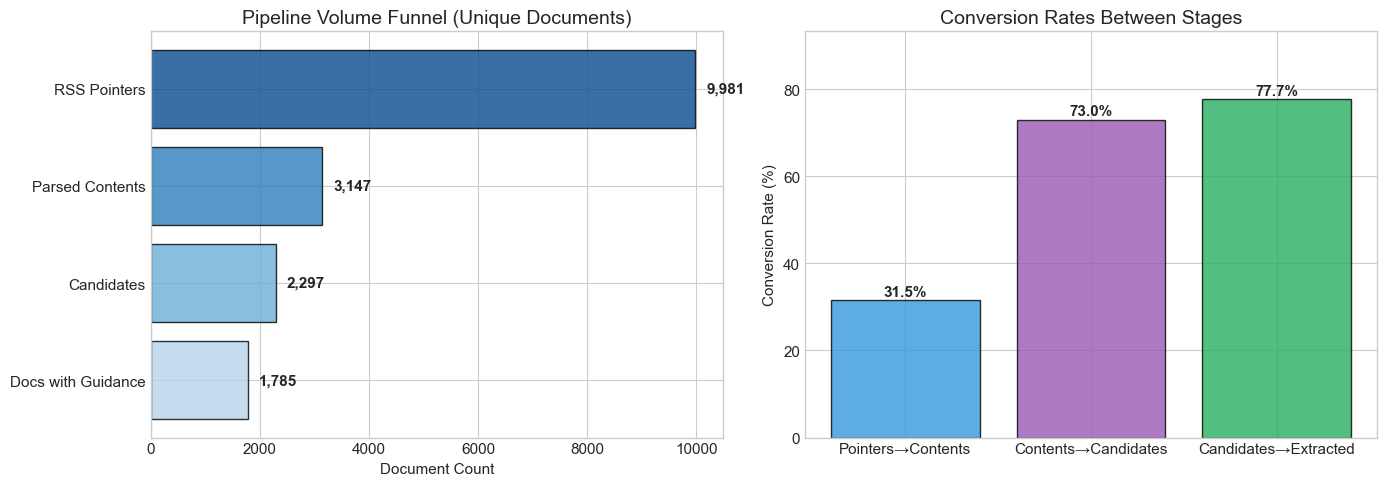


Key Insights:
  • 27.0% of documents filtered out by regex (no guidance patterns)
  • 77.7% of candidate documents yielded extractable guidance
  • Average 5.4 guidance items per document


In [44]:
# Visualize pipeline funnel (by unique documents)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Funnel chart (horizontal bar)
stages = ['RSS Pointers', 'Parsed Contents', 'Candidates', 'Docs with Guidance']
counts = [n_pointers, n_contents, n_candidates, n_extracted_docs]
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(stages)))[::-1]

bars = axes[0].barh(stages[::-1], counts[::-1], color=colors[::-1], edgecolor='black', alpha=0.8)
axes[0].set_title('Pipeline Volume Funnel (Unique Documents)', fontsize=14)
axes[0].set_xlabel('Document Count')

# Add value labels
for bar, count in zip(bars, counts[::-1]):
    width = bar.get_width()
    axes[0].text(width + max(counts)*0.02, bar.get_y() + bar.get_height()/2, 
                 f'{count:,}', va='center', fontsize=11, fontweight='bold')

# Conversion rate waterfall
stage_pairs = ['Pointers→Contents', 'Contents→Candidates', 'Candidates→Extracted']
rates = [content_rate, candidate_rate, extraction_rate]
colors_rates = ['#3498db', '#9b59b6', '#27ae60']

bars2 = axes[1].bar(stage_pairs, rates, color=colors_rates, edgecolor='black', alpha=0.8)
axes[1].set_title('Conversion Rates Between Stages', fontsize=14)
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_ylim(0, max(rates) * 1.2 if rates else 100)

# Add percentage labels
for bar, rate in zip(bars2, rates):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 1, 
                 f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nKey Insights:")
print(f"  • {100 - candidate_rate:.1f}% of documents filtered out by regex (no guidance patterns)")
print(f"  • {extraction_rate:.1f}% of candidate documents yielded extractable guidance")
print(f"  • Average {len(df)/n_extracted_docs:.1f} guidance items per document" if n_extracted_docs > 0 else "")

## 3. Data Overview and Structure

Examine the dataset structure, column types, and sample records.

In [45]:
# Dataset shape and columns
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")

Dataset Shape: 9,568 rows × 26 columns

Columns:
   1. guid
   2. content_uid
   3. source_id
   4. ticker
   5. guidance_type
   6. metric_name
   7. reporting_period
   8. current_value
   9. unit
  10. guided_range_low
  11. guided_range_high
  12. is_revision
  13. revision_direction
  14. qualitative_direction
  15. rationales
  16. statement_text
  17. source_type
  18. extracted_at
  19. extraction_method
  20. processing_duration_seconds
  21. was_updated_by_agent
  22. content_title
  23. published_at
  24. source_link
  25. range_spread
  26. range_midpoint


In [4]:
# Data types overview
print("Data Types:\n")
df.info()

Data Types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   guid                         9568 non-null   object             
 1   content_uid                  9568 non-null   object             
 2   source_id                    9568 non-null   object             
 3   ticker                       9568 non-null   object             
 4   guidance_type                9564 non-null   object             
 5   metric_name                  9568 non-null   object             
 6   reporting_period             9423 non-null   object             
 7   current_value                350 non-null    float64            
 8   unit                         8967 non-null   object             
 9   guided_range_low             8639 non-null   float64            
 10  guided_range_high            5338 n

In [5]:
# Sample records
print("First 5 records (key columns):\n")
key_cols = ['ticker', 'guidance_type', 'metric_name', 'reporting_period', 
            'guided_range_low', 'guided_range_high', 'unit', 'source_type']
df[key_cols].head()

First 5 records (key columns):



,ticker,guidance_type,metric_name,reporting_period,guided_range_low,guided_range_high,unit,source_type
0,MSFT,revenue,Productivity and Business Processes Revenue,Q1 FY2025,20.30,20.60,billion,8-K
1,MSFT,revenue,Intelligent Cloud Revenue,Q1 FY2025,28.60,28.90,billion,8-K
2,MSFT,revenue,More Personal Computing Revenue,Q1 FY2025,14.90,15.30,billion,8-K
3,MSFT,opex,Cost of revenue,Q1 FY2025,19.95,20.15,billion,8-K
4,MSFT,opex,Operating expenses,Q1 FY2025,15.20,15.30,billion,8-K


## 4. Missing Values Analysis

Identify and visualize missing values across all columns to assess data completeness.

In [6]:
# Calculate missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

# Show columns with any missing values
print("Columns with Missing Values:\n")
missing_df[missing_df['Missing Count'] > 0]

Columns with Missing Values:



,Column,Missing Count,Missing %
7,current_value,9218,96.34
13,qualitative_direction,8003,83.64
12,revision_direction,7665,80.11
14,rationales,6026,62.98
10,guided_range_high,4230,44.21
9,guided_range_low,929,9.71
8,unit,601,6.28
6,reporting_period,145,1.52
11,is_revision,43,0.45
4,guidance_type,4,0.04


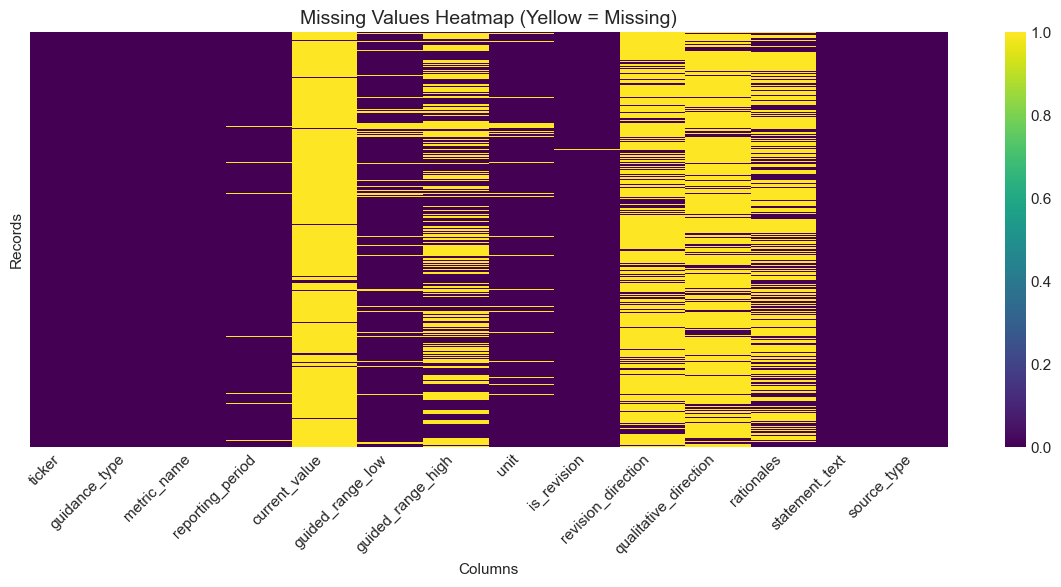

In [7]:
# Visualize missing values heatmap for key columns
key_columns = ['ticker', 'guidance_type', 'metric_name', 'reporting_period',
               'current_value', 'guided_range_low', 'guided_range_high', 'unit',
               'is_revision', 'revision_direction', 'qualitative_direction', 
               'rationales', 'statement_text', 'source_type']

# Filter to columns that exist in dataframe
key_columns = [c for c in key_columns if c in df.columns]

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df[key_columns].isnull(), cbar=True, yticklabels=False, cmap='viridis', ax=ax)
ax.set_title('Missing Values Heatmap (Yellow = Missing)', fontsize=14)
ax.set_xlabel('Columns')
ax.set_ylabel('Records')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Descriptive Statistics

Summary statistics for numerical columns and value distributions for categorical columns.

In [8]:
# Numerical columns statistics
numerical_cols = ['current_value', 'guided_range_low', 'guided_range_high', 'processing_duration_seconds']
numerical_cols = [c for c in numerical_cols if c in df.columns]

print("Numerical Columns Statistics:\n")
df[numerical_cols].describe().round(2)

Numerical Columns Statistics:



,current_value,guided_range_low,guided_range_high,processing_duration_seconds
count,350.00,8.639000e+03,5.338000e+03,9568.00
mean,719.56,2.095801e+07,3.429152e+07,6.16
std,4738.37,1.361887e+09,1.770976e+09,11.76
min,-331.00,-8.500000e+02,-7.500000e+02,3.12
25%,4.54,3.500000e+00,4.800000e+00,4.43
50%,6.51,8.700000e+00,9.000000e+00,4.89
75%,18.00,2.400000e+01,2.119000e+01,5.63
max,71043.00,9.000000e+10,9.200000e+10,373.85


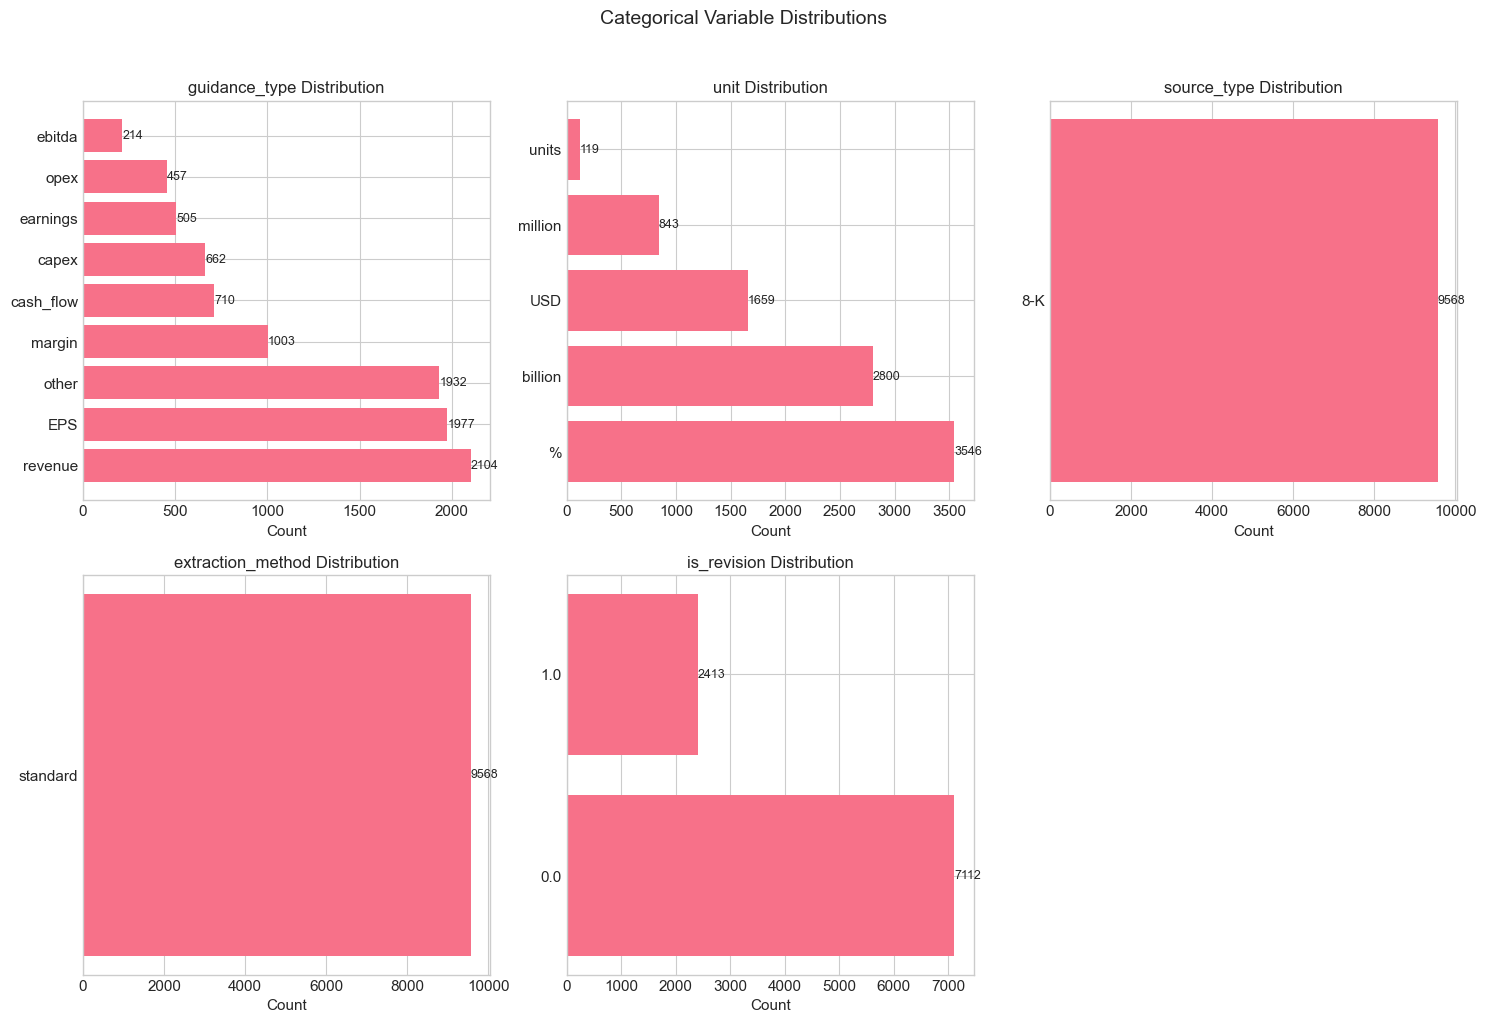

In [9]:
# Categorical columns value counts
categorical_cols = ['guidance_type', 'unit', 'source_type', 'extraction_method', 'is_revision']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        value_counts = df[col].value_counts()
        axes[i].barh(value_counts.index.astype(str), value_counts.values)
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel('Count')
        # Add value labels
        for j, v in enumerate(value_counts.values):
            axes[i].text(v + 0.5, j, str(v), va='center', fontsize=9)

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle('Categorical Variable Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Distribution Analysis: Guidance Types and Tickers

Deep dive into the distribution of guidance types and company coverage.

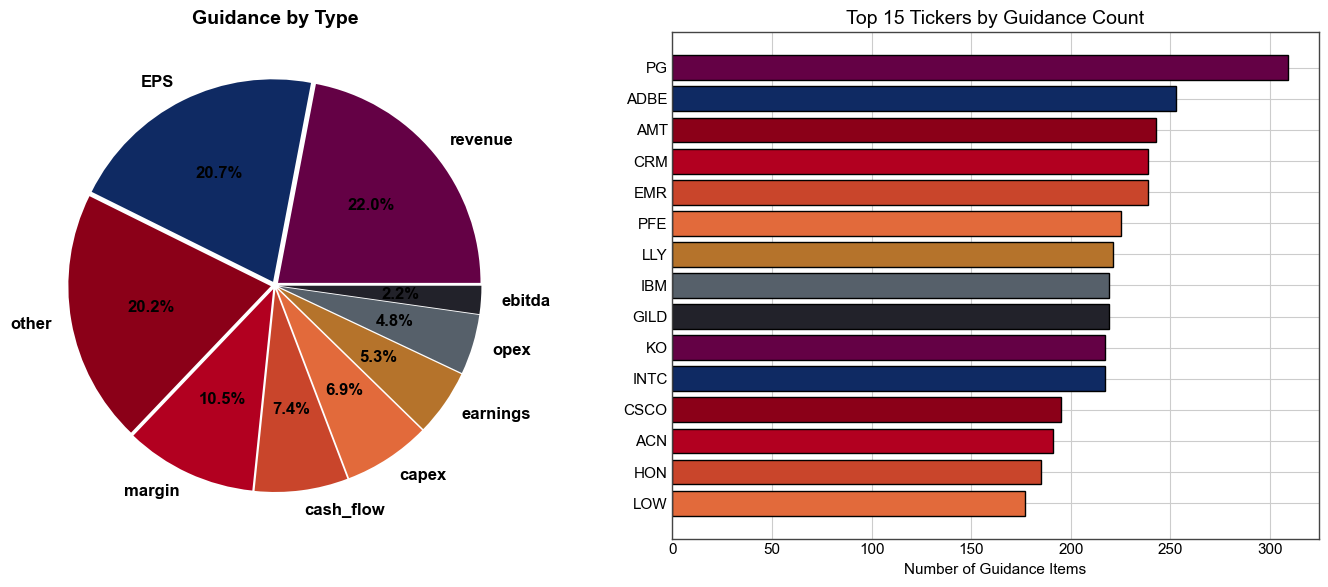


Total unique tickers: 96
Total unique guidance types: 9

Exported: figures/guidance_by_type_transparent.png (transparent bg, white text)


In [46]:
# Guidance type distribution - Pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fixed 9-color dark palette (designed for white text, matching swatch tones)
PALETTE_9 = [
    "#640145",  # deep purple (very dark)
    '#0f2a63',  # deep navy
    '#8b0018',  # deep maroon
    '#b20020',  # strong red
    '#c9452b',  # brick / orange-red
    '#e26a3b',  # muted coral
    '#b5732b',  # muted gold / burnt ochre
    '#56606a',  # slate gray
    '#22222a',  # charcoal
]

def get_colors(n):
    if n <= len(PALETTE_9):
        return PALETTE_9[:n]
    # If more requested, cycle palette (rare); primary requirement was nine distinct colors
    return (PALETTE_9 * ((n // len(PALETTE_9)) + 1))[:n]

# Guidance type pie chart
if 'guidance_type' in df.columns:
    type_counts = df['guidance_type'].value_counts()
    pie_colors = get_colors(len(type_counts))
    wedges, texts, autotexts = axes[0].pie(
        type_counts.values, 
        labels=type_counts.index, 
        autopct='%1.1f%%',
        colors=pie_colors,
        explode=[0.02] * len(type_counts),
        textprops={'color': 'black', 'fontsize': 12, 'fontweight': 'bold'}
    )
    axes[0].set_title('Guidance by Type', fontsize=14, color='black', fontweight='bold')

# Top 15 tickers bar chart
if 'ticker' in df.columns:
    ticker_counts = df['ticker'].value_counts().head(15)
    ticker_colors = get_colors(len(ticker_counts))
    bars = axes[1].barh(ticker_counts.index[::-1], ticker_counts.values[::-1], color=ticker_colors[::-1], edgecolor='black')
    axes[1].set_title('Top 15 Tickers by Guidance Count', fontsize=14, color='black')
    axes[1].set_xlabel('Number of Guidance Items', color='black')
    axes[1].tick_params(axis='x', colors='black')
    axes[1].tick_params(axis='y', colors='black')

# Improve subplot backgrounds for white text contrast
for ax in axes:
    ax.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_color('#444444')

plt.tight_layout()
plt.show()

print(f"\nTotal unique tickers: {df['ticker'].nunique()}")
print(f"Total unique guidance types: {df['guidance_type'].nunique()}")

# --- Export pie chart with transparent background and white text ---
if 'guidance_type' in df.columns:
    fig_export, ax_export = plt.subplots(figsize=(8, 8), facecolor='none')
    ax_export.set_facecolor('none')
    
    type_counts = df['guidance_type'].value_counts()
    export_colors = get_colors(len(type_counts))
    wedges, texts, autotexts = ax_export.pie(
        type_counts.values, 
        labels=type_counts.index, 
        autopct='%1.1f%%',
        colors=export_colors,
        explode=[0.02] * len(type_counts),
        textprops={'color': 'black', 'fontsize': 12, 'fontweight': 'bold'}
    )
    # Ensure percentage text is black and bold
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    ax_export.set_title('Guidance by Type', fontsize=16, color='black', fontweight='bold')
    
    # Save with transparent background
    export_path = Path("figures")
    export_path.mkdir(exist_ok=True)
    fig_export.savefig(
        export_path / "guidance_by_type_transparent.png", 
        dpi=300, 
        transparent=True, 
        bbox_inches='tight'
    )
    plt.close(fig_export)
    print(f"\nExported: figures/guidance_by_type_transparent.png (transparent bg, white text)")

## 7. Temporal Analysis

Analyze guidance extraction patterns over time to identify trends and seasonality.

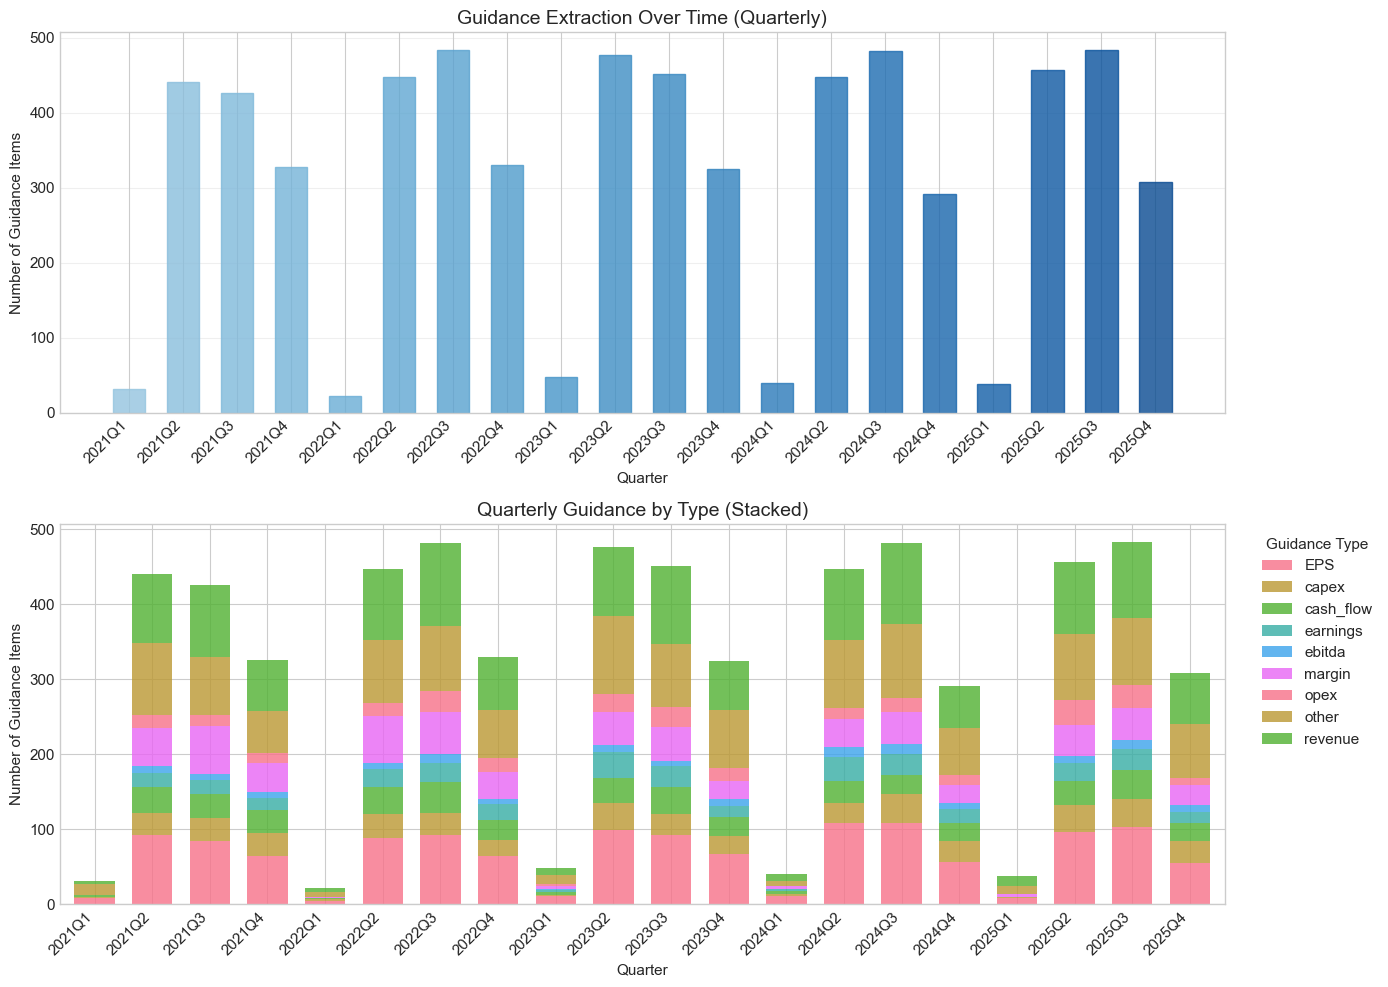


Date range: 2021-03-18 to 2025-10-31
Total quarters: 20


In [22]:
# Time series of guidance extraction - Quarterly bar chart
if df['published_at'].notna().any():
    # Filter to valid dates
    df_temporal = df[df['published_at'].notna()].copy()
    
    # Ensure published_at is datetime
    df_temporal['published_at'] = pd.to_datetime(df_temporal['published_at'], errors='coerce')
    df_temporal = df_temporal[df_temporal['published_at'].notna()]
    
    # Group by quarter
    df_temporal['quarter'] = df_temporal['published_at'].dt.to_period('Q')
    quarterly_counts = df_temporal.groupby('quarter').size()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Quarterly bar chart
    x_labels = [str(q) for q in quarterly_counts.index]
    bars = axes[0].bar(x_labels, quarterly_counts.values, width=0.6, edgecolor='black', alpha=0.8)
    axes[0].set_title('Guidance Extraction Over Time (Quarterly)', fontsize=14)
    axes[0].set_xlabel('Quarter')
    axes[0].set_ylabel('Number of Guidance Items')
    axes[0].grid(True, alpha=0.3, axis='y')
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Color bars by value (gradient)
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Quarterly trend with guidance type breakdown (stacked bar)
    quarterly_by_type = df_temporal.groupby(['quarter', 'guidance_type']).size().unstack(fill_value=0)
    quarterly_by_type.index = [str(q) for q in quarterly_by_type.index]
    
    quarterly_by_type.plot(kind='bar', stacked=True, ax=axes[1], alpha=0.8, width=0.7)
    axes[1].set_title('Quarterly Guidance by Type (Stacked)', fontsize=14)
    axes[1].set_xlabel('Quarter')
    axes[1].set_ylabel('Number of Guidance Items')
    axes[1].legend(title='Guidance Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDate range: {df_temporal['published_at'].min().date()} to {df_temporal['published_at'].max().date()}")
    print(f"Total quarters: {len(quarterly_counts)}")
else:
    print("No valid published_at dates found for temporal analysis")

Top 20 Reporting Periods:



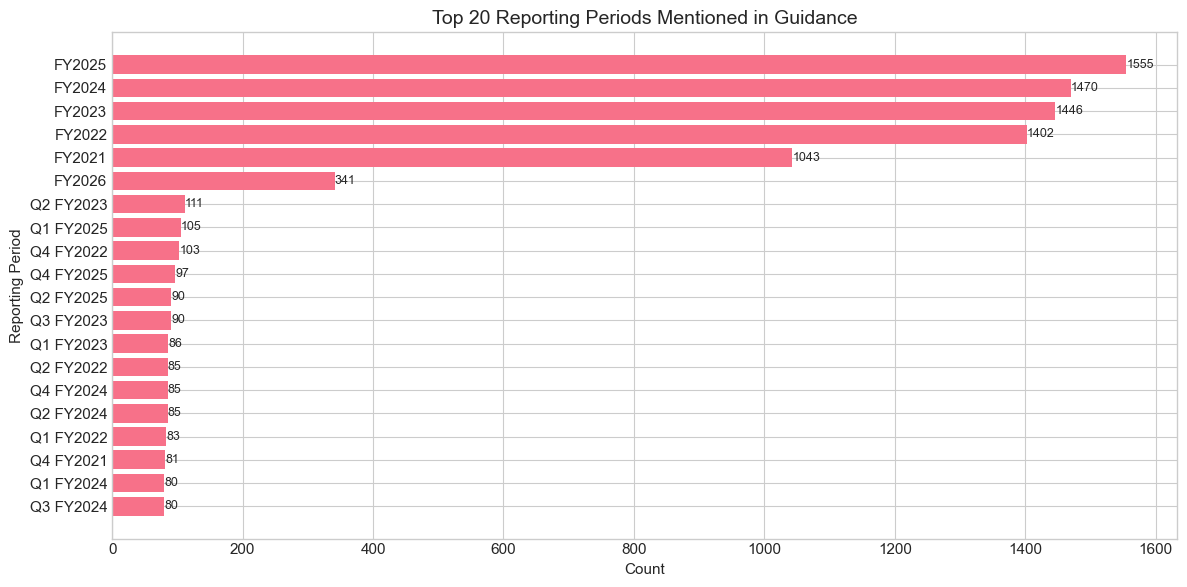

In [12]:
# Reporting period analysis
if 'reporting_period' in df.columns:
    print("Top 20 Reporting Periods:\n")
    period_counts = df['reporting_period'].value_counts().head(20)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(period_counts.index[::-1], period_counts.values[::-1])
    ax.set_title('Top 20 Reporting Periods Mentioned in Guidance', fontsize=14)
    ax.set_xlabel('Count')
    ax.set_ylabel('Reporting Period')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 8. Quantitative Analysis: Guidance Ranges

Analyze the distribution and characteristics of numerical guidance values.

Records with guidance ranges: 5,284 (55.2%)



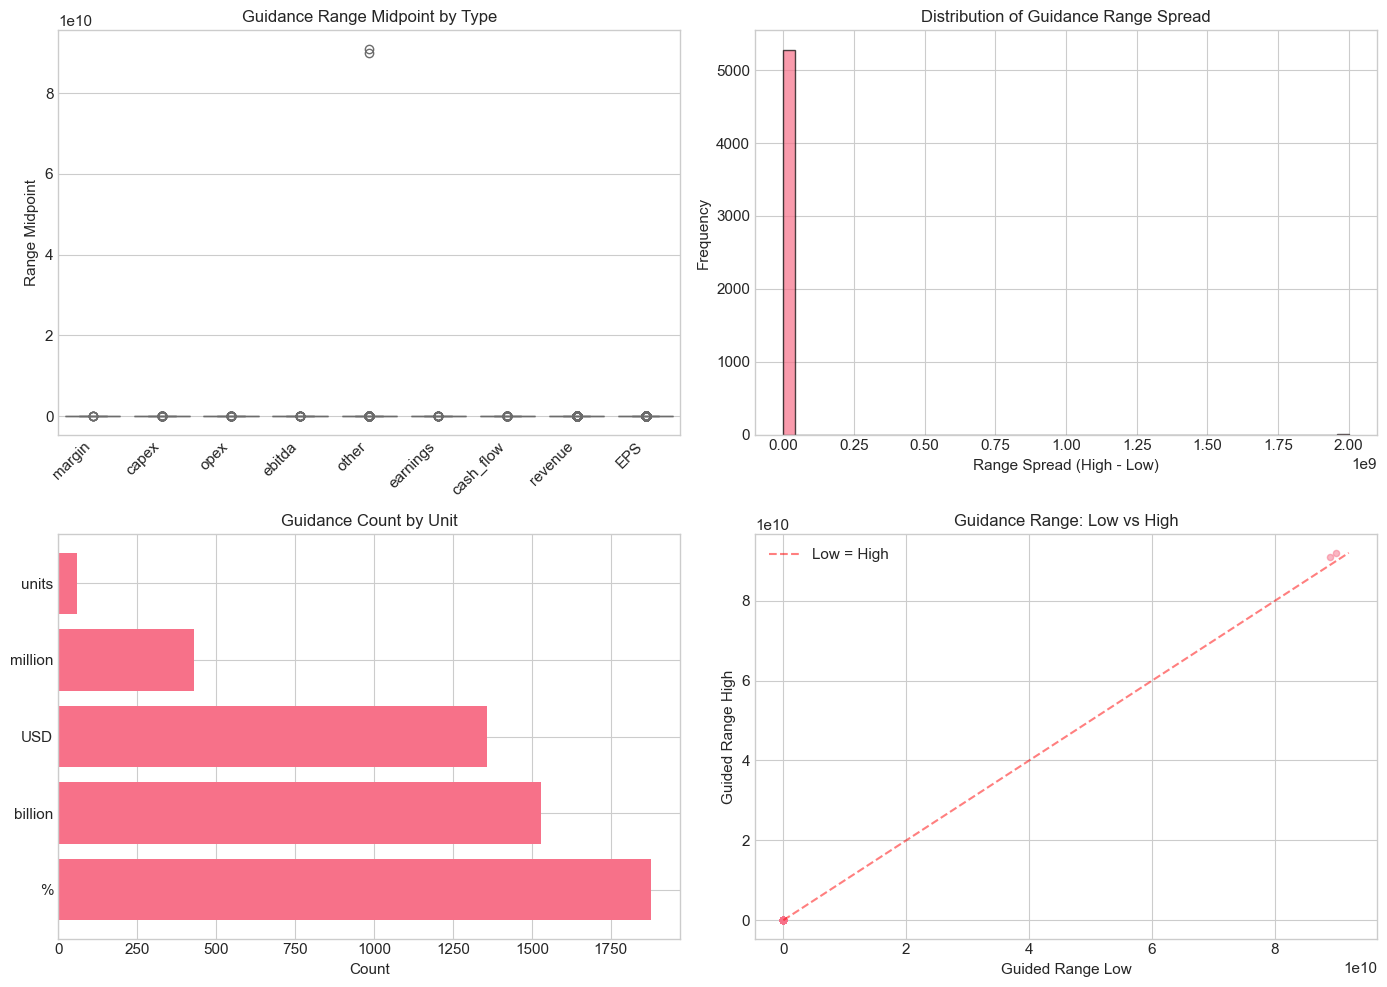

In [13]:
# Calculate range spread (difference between high and low)
df['range_spread'] = df['guided_range_high'] - df['guided_range_low']
df['range_midpoint'] = (df['guided_range_high'] + df['guided_range_low']) / 2

# Filter to records with valid ranges
df_with_ranges = df[(df['guided_range_low'].notna()) & (df['guided_range_high'].notna())].copy()

print(f"Records with guidance ranges: {len(df_with_ranges):,} ({len(df_with_ranges)/len(df)*100:.1f}%)\n")

# Distribution of range spreads by unit
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Range spread distribution
if len(df_with_ranges) > 0:
    # Box plot of range values by guidance type
    axes[0, 0].set_title('Guidance Range Midpoint by Type', fontsize=12)
    df_plot = df_with_ranges[df_with_ranges['range_midpoint'].notna()]
    if len(df_plot) > 0:
        type_order = df_plot.groupby('guidance_type')['range_midpoint'].median().sort_values(ascending=False).index
        sns.boxplot(data=df_plot, x='guidance_type', y='range_midpoint', 
                    order=type_order, ax=axes[0, 0])
        axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
        axes[0, 0].set_ylabel('Range Midpoint')
        axes[0, 0].set_xlabel('')

    # Range spread histogram
    axes[0, 1].hist(df_with_ranges['range_spread'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribution of Guidance Range Spread', fontsize=12)
    axes[0, 1].set_xlabel('Range Spread (High - Low)')
    axes[0, 1].set_ylabel('Frequency')

    # Range values by unit type
    if 'unit' in df_with_ranges.columns:
        unit_stats = df_with_ranges.groupby('unit').agg({
            'range_midpoint': ['mean', 'median', 'count']
        }).round(2)
        unit_stats.columns = ['Mean', 'Median', 'Count']
        unit_stats = unit_stats.sort_values('Count', ascending=False)
        
        axes[1, 0].barh(unit_stats.index, unit_stats['Count'])
        axes[1, 0].set_title('Guidance Count by Unit', fontsize=12)
        axes[1, 0].set_xlabel('Count')
        
    # Scatter: Low vs High range
    axes[1, 1].scatter(df_with_ranges['guided_range_low'], 
                       df_with_ranges['guided_range_high'], 
                       alpha=0.5, s=20)
    # Add diagonal line
    max_val = max(df_with_ranges['guided_range_high'].max(), df_with_ranges['guided_range_low'].max())
    axes[1, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Low = High')
    axes[1, 1].set_title('Guidance Range: Low vs High', fontsize=12)
    axes[1, 1].set_xlabel('Guided Range Low')
    axes[1, 1].set_ylabel('Guided Range High')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9. Outlier Detection

Identify potential outliers and anomalies in the extracted data.

In [14]:
# IQR-based outlier detection for numerical columns
def detect_outliers_iqr(series):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze outliers in key numerical fields
outlier_summary = []
numerical_fields = ['guided_range_low', 'guided_range_high', 'range_spread', 'processing_duration_seconds']

for col in numerical_fields:
    if col in df.columns and df[col].notna().any():
        outliers, lb, ub = detect_outliers_iqr(df[col].dropna())
        outlier_summary.append({
            'Column': col,
            'Total Values': df[col].notna().sum(),
            'Outliers': len(outliers),
            'Outlier %': round(len(outliers) / df[col].notna().sum() * 100, 2),
            'Lower Bound': round(lb, 2),
            'Upper Bound': round(ub, 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Detection Summary (IQR Method):\n")
outlier_df

Outlier Detection Summary (IQR Method):



,Column,Total Values,Outliers,Outlier %,Lower Bound,Upper Bound
0,guided_range_low,8639,1419,16.43,-27.25,54.75
1,guided_range_high,5338,806,15.10,-19.79,45.78
2,range_spread,5284,615,11.64,-2.50,4.70
3,processing_duration_seconds,9568,859,8.98,2.63,7.43


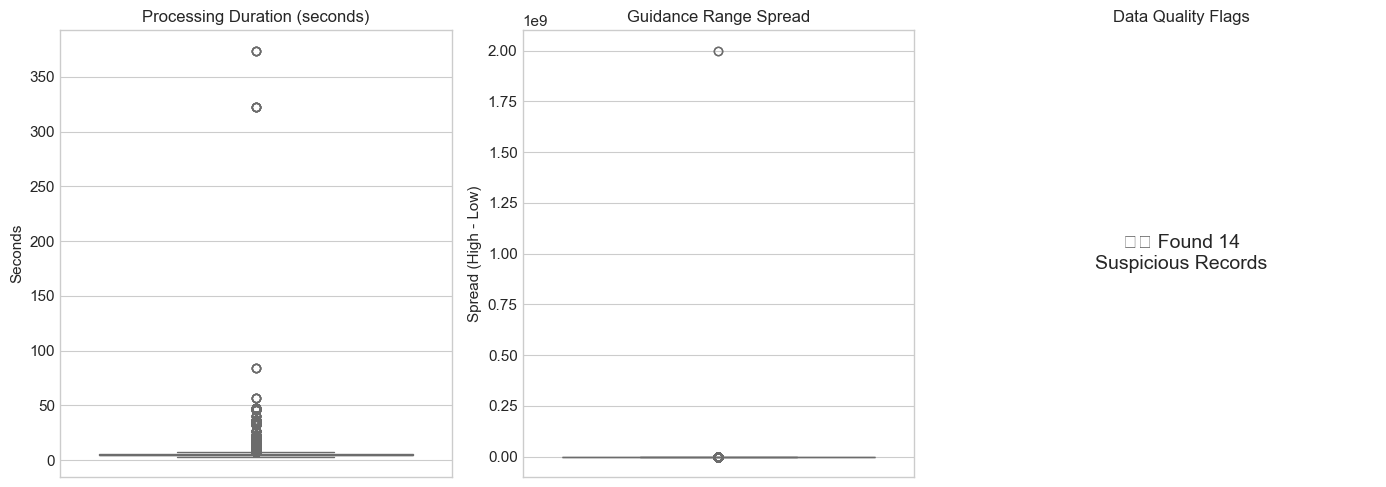


⚠️ 14 suspicious records found (Low > High or negative spread)


In [15]:
# Box plots for outlier visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Processing duration outliers
if 'processing_duration_seconds' in df.columns:
    sns.boxplot(y=df['processing_duration_seconds'].dropna(), ax=axes[0])
    axes[0].set_title('Processing Duration (seconds)', fontsize=12)
    axes[0].set_ylabel('Seconds')

# Range spread outliers (log scale for better visualization)
if 'range_spread' in df.columns and df['range_spread'].notna().any():
    spread_data = df['range_spread'].dropna()
    spread_data = spread_data[spread_data > 0]  # Filter positive values for log
    if len(spread_data) > 0:
        sns.boxplot(y=spread_data, ax=axes[1])
        axes[1].set_title('Guidance Range Spread', fontsize=12)
        axes[1].set_ylabel('Spread (High - Low)')

# Identify potentially suspicious records
suspicious = df[
    (df['guided_range_low'] > df['guided_range_high']) |  # Low > High (error)
    (df['range_spread'] < 0) |  # Negative spread
    (df['processing_duration_seconds'] > 120)  # Very long processing
].copy()

if len(suspicious) > 0:
    axes[2].text(0.5, 0.5, f"⚠️ Found {len(suspicious)}\nSuspicious Records", 
                 ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
    axes[2].set_title('Data Quality Flags', fontsize=12)
else:
    axes[2].text(0.5, 0.5, "✓ No obvious\ndata errors found", 
                 ha='center', va='center', fontsize=14, color='green', transform=axes[2].transAxes)
    axes[2].set_title('Data Quality Flags', fontsize=12)

axes[2].axis('off')

plt.tight_layout()
plt.show()

if len(suspicious) > 0:
    print(f"\n⚠️ {len(suspicious)} suspicious records found (Low > High or negative spread)")

## 10. Revision Analysis

Analyze patterns in guidance revisions (updates to prior guidance).

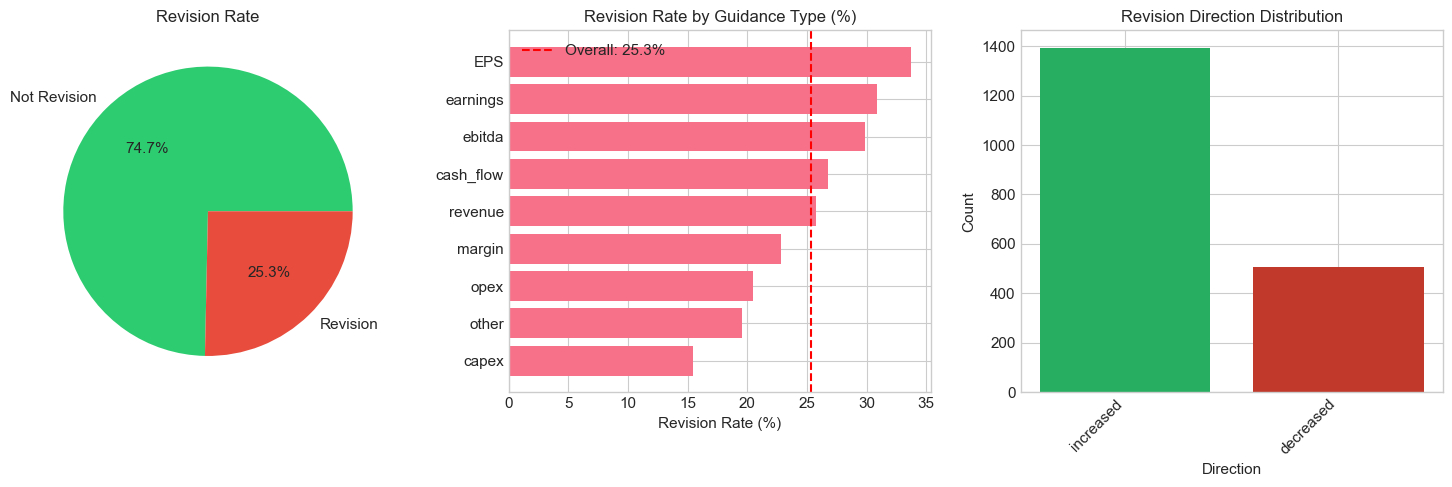


Total revisions: 2,413.0 (25.3% of all guidance)


In [16]:
# Revision analysis
if 'is_revision' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Overall revision rate
    revision_counts = df['is_revision'].value_counts()
    labels = ['Not Revision', 'Revision']
    colors = ['#2ecc71', '#e74c3c']
    axes[0].pie(revision_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    axes[0].set_title('Revision Rate', fontsize=12)
    
    # Revision rate by guidance type
    if 'guidance_type' in df.columns:
        revision_by_type = df.groupby('guidance_type')['is_revision'].mean() * 100
        revision_by_type = revision_by_type.sort_values(ascending=True)
        
        bars = axes[1].barh(revision_by_type.index, revision_by_type.values)
        axes[1].set_title('Revision Rate by Guidance Type (%)', fontsize=12)
        axes[1].set_xlabel('Revision Rate (%)')
        axes[1].axvline(x=df['is_revision'].mean() * 100, color='red', linestyle='--', 
                        label=f'Overall: {df["is_revision"].mean()*100:.1f}%')
        axes[1].legend()
    
    # Revision direction distribution
    if 'revision_direction' in df.columns:
        revisions = df[df['is_revision'] == True]
        if len(revisions) > 0:
            direction_counts = revisions['revision_direction'].value_counts()
            colors = ['#27ae60' if 'increase' in str(d).lower() else '#c0392b' 
                     for d in direction_counts.index]
            axes[2].bar(direction_counts.index.astype(str), direction_counts.values, color=colors)
            axes[2].set_title('Revision Direction Distribution', fontsize=12)
            axes[2].set_xlabel('Direction')
            axes[2].set_ylabel('Count')
            plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal revisions: {df['is_revision'].sum():,} ({df['is_revision'].mean()*100:.1f}% of all guidance)")

## 11. Data Quality Metrics Summary

Comprehensive data quality assessment to determine if the pipeline output is "decent looking".

In [24]:
# Comprehensive data quality metrics
quality_metrics = {
    'Total Records': len(df),
    'Unique Tickers': df['ticker'].nunique(),
    'Unique Guidance Types': df['guidance_type'].nunique() if 'guidance_type' in df.columns else 'N/A',
    'Date Range': f"{df['published_at'].min().date() if df['published_at'].notna().any() else 'N/A'} to {df['published_at'].max().date() if df['published_at'].notna().any() else 'N/A'}",
}

# Completeness metrics
completeness = {
    'Ticker': df['ticker'].notna().mean() * 100,
    'Guidance Type': df['guidance_type'].notna().mean() * 100 if 'guidance_type' in df.columns else 0,
    'Metric Name': df['metric_name'].notna().mean() * 100 if 'metric_name' in df.columns else 0,
    'Reporting Period': df['reporting_period'].notna().mean() * 100 if 'reporting_period' in df.columns else 0,
    'Range Low': df['guided_range_low'].notna().mean() * 100 if 'guided_range_low' in df.columns else 0,
    'Range High': df['guided_range_high'].notna().mean() * 100 if 'guided_range_high' in df.columns else 0,
    'Unit': df['unit'].notna().mean() * 100 if 'unit' in df.columns else 0
}

print("=" * 60)
print("PIPELINE OUTPUT QUALITY SUMMARY")
print("=" * 60)
print("\n📊 Dataset Overview:")
for k, v in quality_metrics.items():
    print(f"   {k}: {v}")

print("\n✅ Field Completeness (% non-null):")
for k, v in completeness.items():
    status = "✓" if v >= 80 else "⚠" if v >= 50 else "✗"
    print(f"   {status} {k}: {v:.1f}%")

# Overall quality score
avg_completeness = np.mean(list(completeness.values()))
print(f"\n📈 Average Field Completeness: {avg_completeness:.1f}%")
print("=" * 60)

PIPELINE OUTPUT QUALITY SUMMARY

📊 Dataset Overview:
   Total Records: 9568
   Unique Tickers: 96
   Unique Guidance Types: 9
   Date Range: 2021-01-06 to 2026-01-22

✅ Field Completeness (% non-null):
   ✓ Ticker: 100.0%
   ✓ Guidance Type: 100.0%
   ✓ Metric Name: 100.0%
   ✓ Reporting Period: 98.5%
   ✓ Range Low: 90.3%
   ⚠ Range High: 55.8%
   ✓ Unit: 93.7%

📈 Average Field Completeness: 91.2%


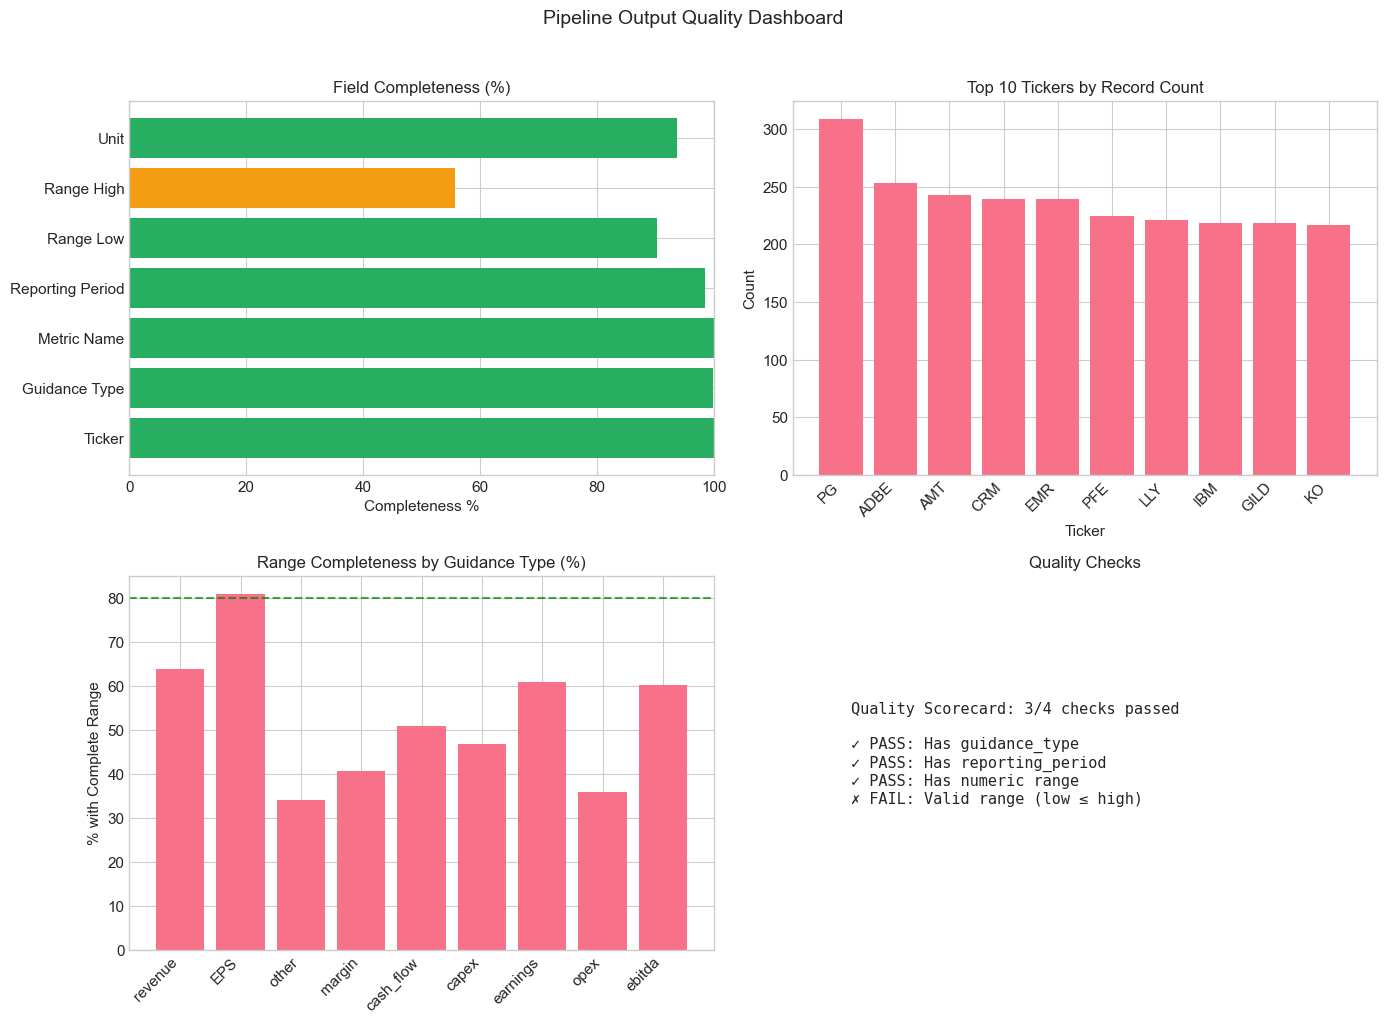

In [25]:
# Visual quality dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Completeness bar chart
completeness_df = pd.DataFrame(list(completeness.items()), columns=['Field', 'Completeness'])
colors = ['#27ae60' if v >= 80 else '#f39c12' if v >= 50 else '#e74c3c' 
          for v in completeness_df['Completeness']]
bars = axes[0, 0].barh(completeness_df['Field'], completeness_df['Completeness'], color=colors)
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_title('Field Completeness (%)', fontsize=12)
axes[0, 0].set_xlabel('Completeness %')
axes[0, 0].legend(loc='lower right')

# 2. Records per ticker (top 10)
ticker_counts = df['ticker'].value_counts().head(10)
axes[0, 1].bar(ticker_counts.index, ticker_counts.values)
axes[0, 1].set_title('Top 10 Tickers by Record Count', fontsize=12)
axes[0, 1].set_xlabel('Ticker')
axes[0, 1].set_ylabel('Count')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Guidance type quality (completeness of ranges by type)
if 'guidance_type' in df.columns:
    type_quality = df.groupby('guidance_type').apply(
        lambda x: pd.Series({
            'Range Complete': (x['guided_range_low'].notna() & x['guided_range_high'].notna()).mean() * 100,
            'Count': len(x)
        })
    )
    type_quality = type_quality.sort_values('Count', ascending=False)
    
    x_pos = np.arange(len(type_quality))
    axes[1, 0].bar(x_pos, type_quality['Range Complete'])
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(type_quality.index, rotation=45, ha='right')
    axes[1, 0].set_title('Range Completeness by Guidance Type (%)', fontsize=12)
    axes[1, 0].set_ylabel('% with Complete Range')
    axes[1, 0].axhline(y=80, color='green', linestyle='--', alpha=0.7)

# 4. Quality summary scorecard
quality_checks = {
    'Has guidance_type': df['guidance_type'].notna().mean() >= 0.95 if 'guidance_type' in df.columns else False,
    'Has reporting_period': df['reporting_period'].notna().mean() >= 0.70 if 'reporting_period' in df.columns else False,
    'Has numeric range': ((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).mean() >= 0.50,
    'Valid range (low ≤ high)': (df['guided_range_low'] <= df['guided_range_high']).mean() >= 0.95 if 'guided_range_low' in df.columns else True
}

passed = sum(quality_checks.values())
total = len(quality_checks)

# Create scorecard text
scorecard_text = f"Quality Scorecard: {passed}/{total} checks passed\n\n"
for check, passed_check in quality_checks.items():
    status = "✓ PASS" if passed_check else "✗ FAIL"
    scorecard_text += f"{status}: {check}\n"

axes[1, 1].text(0.1, 0.5, scorecard_text, fontsize=11, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_title('Quality Checks', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Pipeline Output Quality Dashboard', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 13. Sample Records Inspection

Examine a random sample of records to qualitatively assess extraction quality.

In [26]:
# Display random sample of well-populated records for qualitative inspection
sample_cols = ['ticker', 'guidance_type', 'metric_name', 'reporting_period', 
               'guided_range_low', 'guided_range_high', 'unit', 'is_revision', 'source_type']
sample_cols = [c for c in sample_cols if c in df.columns]

# Get records with complete key fields
complete_records = df[
    df['ticker'].notna() & 
    df['guidance_type'].notna() & 
    df['guided_range_low'].notna()
]

print(f"Sample of {min(10, len(complete_records))} well-populated records:\n")
complete_records[sample_cols].sample(min(10, len(complete_records)), random_state=42)

Sample of 10 well-populated records:



,ticker,guidance_type,metric_name,reporting_period,guided_range_low,guided_range_high,unit,is_revision,source_type
7823,AMT,capex,Total,FY2022,1940.00,2040.00,million,0.0,8-K
4898,KO,cash_flow,cash flow from operations,FY2021,12.00,NaN,billion,1.0,8-K
281,GOOGL,capex,capital expenditures,FY2025,75.00,NaN,billion,0.0,8-K
4572,PG,EPS,Core EPS growth,FY2022,3.00,6.00,%,0.0,8-K
391,AVGO,cash_flow,dividend policy,None,50.00,NaN,%,0.0,8-K
6170,GE,cash_flow,GE HealthCare free cash flow,FY2022,2.10,2.30,billion,0.0,8-K
851,AMD,revenue,revenue,Q2 FY2025,7.10,7.70,billion,0.0,8-K
8832,NEE,other,dividends per share growth rate,FY2024,10.00,NaN,%,0.0,8-K
9045,SPG,EPS,net income attributable to common stockholders...,FY2024,7.38,7.53,USD,1.0,8-K
3915,GILD,EPS,Non-GAAP projected diluted EPS,FY2023,6.45,6.80,USD,1.0,8-K


In [27]:
# Examine a single record in detail with its source text
if 'statement_text' in df.columns and len(complete_records) > 0:
    sample_record = complete_records.sample(1, random_state=123).iloc[0]
    
    print("=" * 70)
    print("DETAILED RECORD INSPECTION")
    print("=" * 70)
    print(f"\n📌 Ticker: {sample_record.get('ticker', 'N/A')}")
    print(f"📊 Type: {sample_record.get('guidance_type', 'N/A')}")
    print(f"📋 Metric: {sample_record.get('metric_name', 'N/A')}")
    print(f"📅 Period: {sample_record.get('reporting_period', 'N/A')}")
    print(f"💰 Range: {sample_record.get('guided_range_low', 'N/A')} - {sample_record.get('guided_range_high', 'N/A')} {sample_record.get('unit', '')}")
    print(f"🔄 Revision: {sample_record.get('is_revision', 'N/A')}")
    print(f"📁 Source Type: {sample_record.get('source_type', 'N/A')}")
    print(f"\n📝 Statement Text:\n")
    
    statement = sample_record.get('statement_text', 'N/A')
    if isinstance(statement, str) and len(statement) > 500:
        print(statement[:500] + "...")
    else:
        print(statement)
    print("=" * 70)

DETAILED RECORD INSPECTION

📌 Ticker: CSCO
📊 Type: revenue
📋 Metric: Revenue
📅 Period: FY2024
💰 Range: 57.0 - 58.2 billion
🔄 Revision: 0.0
📁 Source Type: 8-K

📝 Statement Text:

Cisco expects to achieve the following results for fiscal 2024: FY 2024 Revenue $57.0 billion - $58.2 billion


## 14. Conclusions and Next Steps

Summary of EDA findings and recommendations for pipeline improvement.

In [28]:
# Generate summary statistics for thesis
summary = f"""
================================================================================
                    EDA SUMMARY FOR THESIS DOCUMENTATION
================================================================================

DATASET OVERVIEW:
- Total guidance records extracted: {len(df):,}
- Unique companies (tickers): {df['ticker'].nunique()}
- Guidance types covered: {df['guidance_type'].nunique() if 'guidance_type' in df.columns else 'N/A'}
- Date range: {df['published_at'].min().date() if df['published_at'].notna().any() else 'N/A'} to {df['published_at'].max().date() if df['published_at'].notna().any() else 'N/A'}

DATA COMPLETENESS:
- Average field completeness: {avg_completeness:.1f}%
- Records with numeric guidance ranges: {((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).sum():,} ({((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).mean()*100:.1f}%)
- Records with statement text: {df['statement_text'].notna().sum() if 'statement_text' in df.columns else 'N/A'}

QUALITY INDICATORS:
- Quality checks passed: {passed}/{total}
- Revision rate: {df['is_revision'].mean()*100:.1f}% (indicates pipeline captures updates)
- Average processing time: {df['processing_duration_seconds'].mean():.1f}s per record

NEXT STEPS FOR THESIS:
1. Compare extracted guidance against ground truth (separate evaluation section)
2. Analyze extraction errors for common failure patterns
3. Document pipeline strengths and limitations
4. Consider field-level accuracy metrics (precision, recall, F1)
================================================================================
"""

print(summary)


                    EDA SUMMARY FOR THESIS DOCUMENTATION

DATASET OVERVIEW:
- Total guidance records extracted: 9,568
- Unique companies (tickers): 96
- Guidance types covered: 9
- Date range: 2021-01-06 to 2026-01-22

DATA COMPLETENESS:
- Average field completeness: 91.2%
- Records with numeric guidance ranges: 8,693 (90.9%)
- Records with statement text: 9568

QUALITY INDICATORS:
- Quality checks passed: 3/4
- Revision rate: 25.3% (indicates pipeline captures updates)
- Average processing time: 6.2s per record

NEXT STEPS FOR THESIS:
1. Compare extracted guidance against ground truth (separate evaluation section)
2. Analyze extraction errors for common failure patterns
3. Document pipeline strengths and limitations
4. Consider field-level accuracy metrics (precision, recall, F1)



In [ ]:
# Close database connection
conn.close()
print("Database connection closed.")